In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.4 MB/s 
     |████████████████████████████████| 117 kB 55.8 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=ac56dc782c465db12d8ebd3ebae615805d687524baf1a47cf7eb027fbb27a469
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 5.3 MB/s 
     |████████████████████████████████| 5.9 MB 51.8 MB/s 
     |████████████████████████████████| 419 kB 55.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_path import img_show
from src.utils.display_image_from_array import img_show_from_arr

In [6]:
def delete_border_lines(mask, x_ratio, y_ratio):
  height, width, depth = mask.shape
  vertical_limit = int(height * y_ratio)
  horizontal_limit = int(width * x_ratio)
  # delete upper border
  for i in range(0, vertical_limit):
    for j in range(width):
      mask[i][j][0] = 0
      mask[i][j][1] = 0
      mask[i][j][2] = 0
  # delete left border
  for i in range(height):
    for j in range(0, horizontal_limit):
      mask[i][j][0] = 0
      mask[i][j][1] = 0
      mask[i][j][2] = 0
  # delete lower border
  for i in range(height-vertical_limit, height):
    for j in range(width):
      mask[i][j][0] = 0
      mask[i][j][1] = 0
      mask[i][j][2] = 0
  # delete right border
  for i in range(height):
    for j in range(width - horizontal_limit, width):
      mask[i][j][0] = 0
      mask[i][j][1] = 0
      mask[i][j][2] = 0
  return mask

In [7]:
def next_neighbor_as_zero(height, width, mask):

  pixels_having_0_as_neighbor = []

  for i in range(1, height-1):
    for j in range(1, width-1):
      if mask[i][j][0] != 0:
        if mask[i-1][j][0] == 0: # downstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j-1][0] == 0: # left neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i+1][j][0] == 0: # upstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j+1][0] == 0: # right neighbor
          pixels_having_0_as_neighbor.append((i, j))
  return pixels_having_0_as_neighbor

In [8]:
def get_row_heights(bbox_y_pairs):
  row_heights = []
  for pair in bbox_y_pairs:
    row_height = abs(pair[0]-pair[1])
    row_heights.append(row_height)
  return row_heights

In [9]:
def get_col_widths(bbox_x_pairs):
  col_widths = []
  for pair in bbox_x_pairs:
    col_width = abs(pair[0]-pair[1])
    col_widths.append(col_width)
  return col_widths

In [10]:
def erase_lines_with_small_width(mask, bbox_x_pairs, safety_erase_ratio_width, col_width_limit):
  height, width, depth = mask.shape
  for pair in bbox_x_pairs:
    if abs(pair[0] - pair[1]) < col_width_limit:
      for i in range(height):
        for j in range(pair[0], pair[1]+int(width*safety_erase_ratio_width)):
          mask[i][j][0] = 0
          mask[i][j][1] = 0
          mask[i][j][2] = 0
  return mask

In [11]:
def erase_lines_with_small_height(mask, bbox_y_pairs, safety_erase_ratio_height, row_height_limit):
  height, width, depth = mask.shape
  for pair in bbox_y_pairs:
    if abs(pair[0] - pair[1]) < row_height_limit:
      for i in range(pair[0], pair[1]+int(height*safety_erase_ratio_height)):
        for j in range(width):
          mask[i][j][0] = 0
          mask[i][j][1] = 0
          mask[i][j][2] = 0
  return mask

In [12]:
def find_image_page_type(cols, line_gap_ratio):
  min_col_num = min(cols)
  max_col_num = max(cols)
  lines_area_width = abs(min_col_num - max_col_num) 
  line_gap_threshold = lines_area_width * line_gap_ratio
  for i in range(len(cols)-1):
    if (cols[i+1] - cols[i]) > line_gap_threshold:
      return "two page image"
  return "one_page_image"

In [13]:
def create_row_patches(y1, y2, coords):
  row_patch_coords = []
  for coord in coords:
    if coord[0] >= y1 and coord[0] <= y2:
      row_patch_coords.append(coord)
  return row_patch_coords

In [14]:
def create_unique_patch_cols(patch):
  patch_cols = [patch[i][1] for i in range(len(patch))]
  patch_cols = sorted(patch_cols)
  patch_cols = np.array(patch_cols)
  patch_unique_cols = np.unique(patch_cols)
  return patch_unique_cols

In [15]:
def get_patch_map(row_patches, coords, patch_unique_col_size_limit_ratio):
  patch_unique_col_size = []
  patch_unique_cols_list = []
  created_patches = []

  for row_pair in row_patches:
    patch = create_row_patches(row_pair[0], row_pair[1], coords)
    created_patches.append(patch)
    patch_unique_cols = create_unique_patch_cols(patch)
    patch_unique_cols_list.append(patch_unique_cols)
    patch_unique_col_size.append(len(patch_unique_cols))

  patch_unique_col_size = np.array(patch_unique_col_size)
  patch_unique_col_size_limit = np.mean(patch_unique_col_size) * patch_unique_col_size_limit_ratio
  patch_unique_col_size_limit = [patch_unique_col_size_limit] * len(created_patches)
  patch_unique_col_size_limit 

  patch_map = list(zip( created_patches, patch_unique_cols_list, patch_unique_col_size, patch_unique_col_size_limit))
  return patch_map

In [16]:
def create_bbox_list(rows, cols, line_gap_ratio, coords, patch_unique_col_size_limit_ratio):
  page_type = find_image_page_type(cols, line_gap_ratio)
  print(page_type)
  bbox_list = []
  idx = 0
  patch_map = get_patch_map(rows, coords, patch_unique_col_size_limit_ratio)
  if page_type == "two page image":
    line_gap_threshold = abs(min(cols) - max(cols)) * line_gap_ratio
    for row_pair in rows:
      y1 = row_pair[0]
      y2 = row_pair[1]
      patch = patch_map[idx][0]
      patch_unique_cols = patch_map[idx][1]
      patch_unique_col_size = patch_map[idx][2]
      patch_unique_col_size_limit = patch_map[idx][3]
      idx += 1
      x_min = min(patch_unique_cols)
      x_max = max(patch_unique_cols)
      if patch_unique_col_size > patch_unique_col_size_limit:
        for i in range(len(patch_unique_cols)-1):
          if abs(patch_unique_cols[i] - patch_unique_cols[i+1]) > line_gap_threshold:
            bbox_list.append((x_min, y1, patch_unique_cols[i], y2))
            bbox_list.append((patch_unique_cols[i+1], y1, x_max, y2))
      else:
        bbox_list.append((x_min, y1, x_max, y2))

  else:
    for row_pair in rows:
      y1 = row_pair[0]
      y2 = row_pair[1]
      patch = patch_map[idx][0]
      patch_unique_cols = patch_map[idx][1]
      x_min = min(patch_unique_cols)
      x_max = max(patch_unique_cols)
      bbox_list.append((x_min, y1, x_max, y2))

  return bbox_list

In [17]:
def create_line_image_from_bbox(bbox, img, safety_gap_x, safety_gap_y):
  x1, y1, x2, y2 = bbox
  row = img[y1-safety_gap_y:y2+safety_gap_y, x1-safety_gap_x:x2+safety_gap_x, :]
  return row

def create_row_images(bbox_list, img, safety_gap_x, safety_gap_y):
  rows = []
  for i in range(len(bbox_list)):
    row = create_line_image_from_bbox(bbox_list[i], img, safety_gap_x, safety_gap_y)
    rows.append(row)
  return rows

In [18]:
def get_bboxes_from_mask(mask, 
                         x_ratio, 
                         y_ratio, 
                         col_width_limit_ratio,
                         row_height_limit_ratio, 
                         safety_erase_ratio_width, 
                         safety_erase_ratio_height, 
                         line_gap_ratio,
                         patch_unique_col_size_limit_ratio):
  
  next_neighbor0_rows = []
  bbox_ycoords = []
  bbox_xcoords = []
  row_patches = []
  next_neighbor0_cols = []
  mask = img_mask.copy()
  mask = delete_border_lines(mask, x_ratio, y_ratio)

  height, width, depth = img.shape
  next_neighbor0_coords = next_neighbor_as_zero(height, width, mask)

  next_neighbor0_mask = np.zeros(img.shape)
  for coord in next_neighbor0_coords:
    next_neighbor0_mask[coord[0]][coord[1]][0] = 255
    next_neighbor0_mask[coord[0]][coord[1]][1] = 255
    next_neighbor0_mask[coord[0]][coord[1]][2] = 255
  img_show_from_arr(next_neighbor0_mask)

  for coord in next_neighbor0_coords:
    next_neighbor0_cols.append(coord[1])
  next_neighbor0_cols = np.array(next_neighbor0_cols)
  next_neighbor0_unique_cols = np.unique(next_neighbor0_cols)

  bbox_xcoords.append(next_neighbor0_unique_cols[0])
  for i in range(len(next_neighbor0_unique_cols)-1):
    if abs(next_neighbor0_unique_cols[i] - next_neighbor0_unique_cols[i+1]) > 3:
      bbox_xcoords.append(next_neighbor0_unique_cols[i])
      bbox_xcoords.append(next_neighbor0_unique_cols[i+1])
  bbox_xcoords.append(next_neighbor0_unique_cols[-1])
  bbox_xcoords_pair = [(bbox_xcoords[i], bbox_xcoords[i+1]) for i in range(0, len(bbox_xcoords), 2)]

  col_widths = get_col_widths(bbox_xcoords_pair)
  mean_col_width = np.mean(col_widths)
  col_width_limit = mean_col_width * col_width_limit_ratio

  next_neighbor0_mask = erase_lines_with_small_width(next_neighbor0_mask, bbox_xcoords_pair, safety_erase_ratio_width, col_width_limit)
  next_neighbor0_coords = next_neighbor_as_zero(height, width, next_neighbor0_mask)
  img_show_from_arr(next_neighbor0_mask)

  for coord in next_neighbor0_coords:
    next_neighbor0_rows.append(coord[0])
  next_neighbor0_rows = np.array(next_neighbor0_rows)
  next_neighbor0_unique_rows = np.unique(next_neighbor0_rows)

  bbox_ycoords.append(next_neighbor0_unique_rows[0])
  for i in range(len(next_neighbor0_unique_rows)-1):
    if abs(next_neighbor0_unique_rows[i] - next_neighbor0_unique_rows[i+1]) > 3:
      bbox_ycoords.append(next_neighbor0_unique_rows[i])
      bbox_ycoords.append(next_neighbor0_unique_rows[i+1])
  bbox_ycoords.append(next_neighbor0_unique_rows[-1])
  bbox_ycoords_pair = [(bbox_ycoords[i], bbox_ycoords[i+1]) for i in range(0, len(bbox_ycoords), 2)]

  row_heights = get_row_heights(bbox_ycoords_pair)
  mean_row_height = np.mean(row_heights)
  row_height_limit = mean_row_height * row_height_limit_ratio 

  next_neighbor0_mask = erase_lines_with_small_height(next_neighbor0_mask, bbox_ycoords_pair, safety_erase_ratio_height, row_height_limit)
  next_neighbor0_coords = next_neighbor_as_zero(height, width, next_neighbor0_mask)
  img_show_from_arr(next_neighbor0_mask)

  next_neighbor0_cols = []
  for coord in next_neighbor0_coords:
    next_neighbor0_cols.append(coord[1])
  next_neighbor0_cols = np.array(next_neighbor0_cols)
  next_neighbor0_unique_cols = np.unique(next_neighbor0_cols)

  for pair in bbox_ycoords_pair:
    if abs(pair[0] - pair[1]) > row_height_limit:
      row_patches.append(pair)

  bboxes = create_bbox_list(row_patches, next_neighbor0_unique_cols, line_gap_ratio, next_neighbor0_coords, patch_unique_col_size_limit_ratio)
  return bboxes

In [19]:
def save_line_images(lines, img_path):
    filename = img_path.split("/")[-1].split(".")[0]

    if not (os.path.exists(filename + " Lines")):
        os.mkdir(filename + " Lines")
        
    for i in range(len(lines)):
      cv2.imwrite(filename + " Lines/" + filename + "_line_" + str(i) + ".png", lines[i])

In [20]:
def display_and_save_line_images(bboxes, img, safety_gap_x, safety_gap_y, save=False, img_path=None):
  rows = create_row_images(bboxes, img, safety_gap_x, safety_gap_y)
  img_show_from_arr(img)
  for row in rows:
    img_show_from_arr(row)

  if save:
    save_line_images(rows, img_path)

In [ ]:
img_path = "/content/drive/MyDrive/Images/OMERFAZILAKOZ17-211.jpeg"
img = cv2.imread(img_path)
img_mask = cv2.imread("/content/drive/MyDrive/output/test_page_predicted_masks/OMERFAZILAKOZ17-211_mask_480x480.png")

img_show_from_arr(img)
img_show_from_arr(img_mask)

In [ ]:
cfg = {
    "img_path": img_path,
    "x_ratio": 0.05,
    "y_ratio": 0.1,
    "col_width_limit_ratio": 0.1,
    "row_height_limit_ratio": 0.1,
    "line_gap_ratio": 0.12,
    "safety_gap_x": 10,
    "safety_gap_y": 5,
    "safety_erase_ratio_width": 0.01,
    "safety_erase_ratio_height": 0.01,
    "patch_unique_col_size_limit_ratio": 0.8
}

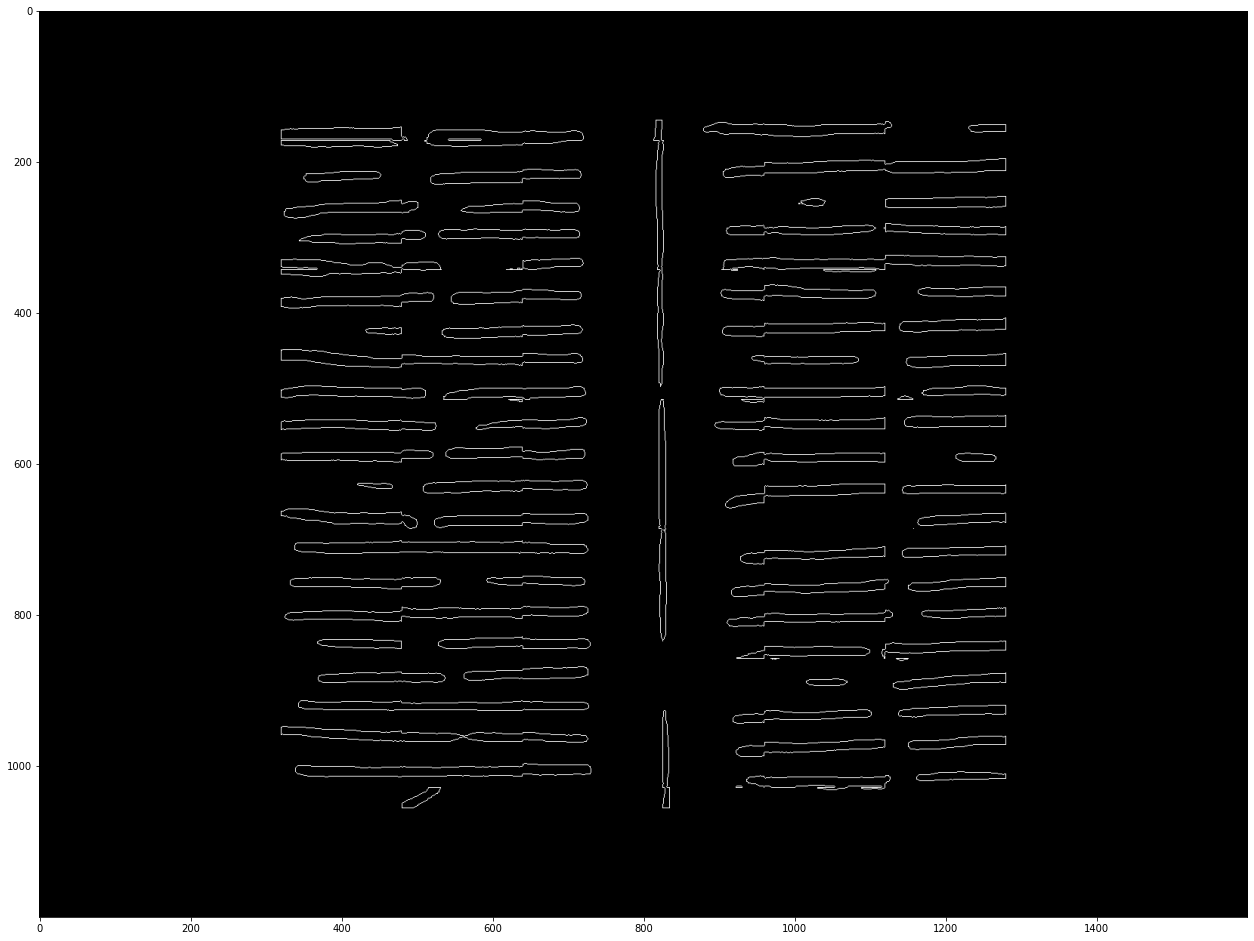

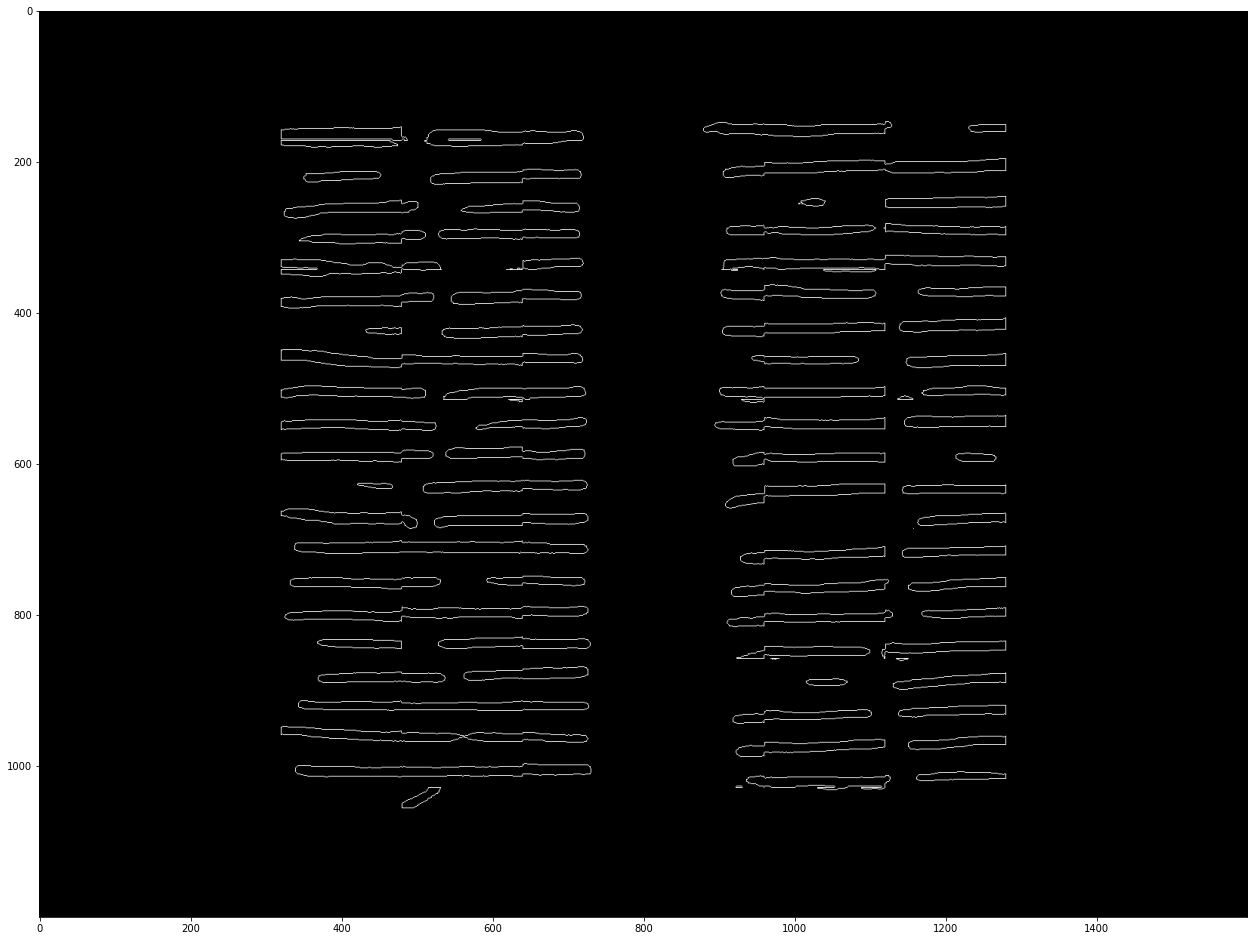

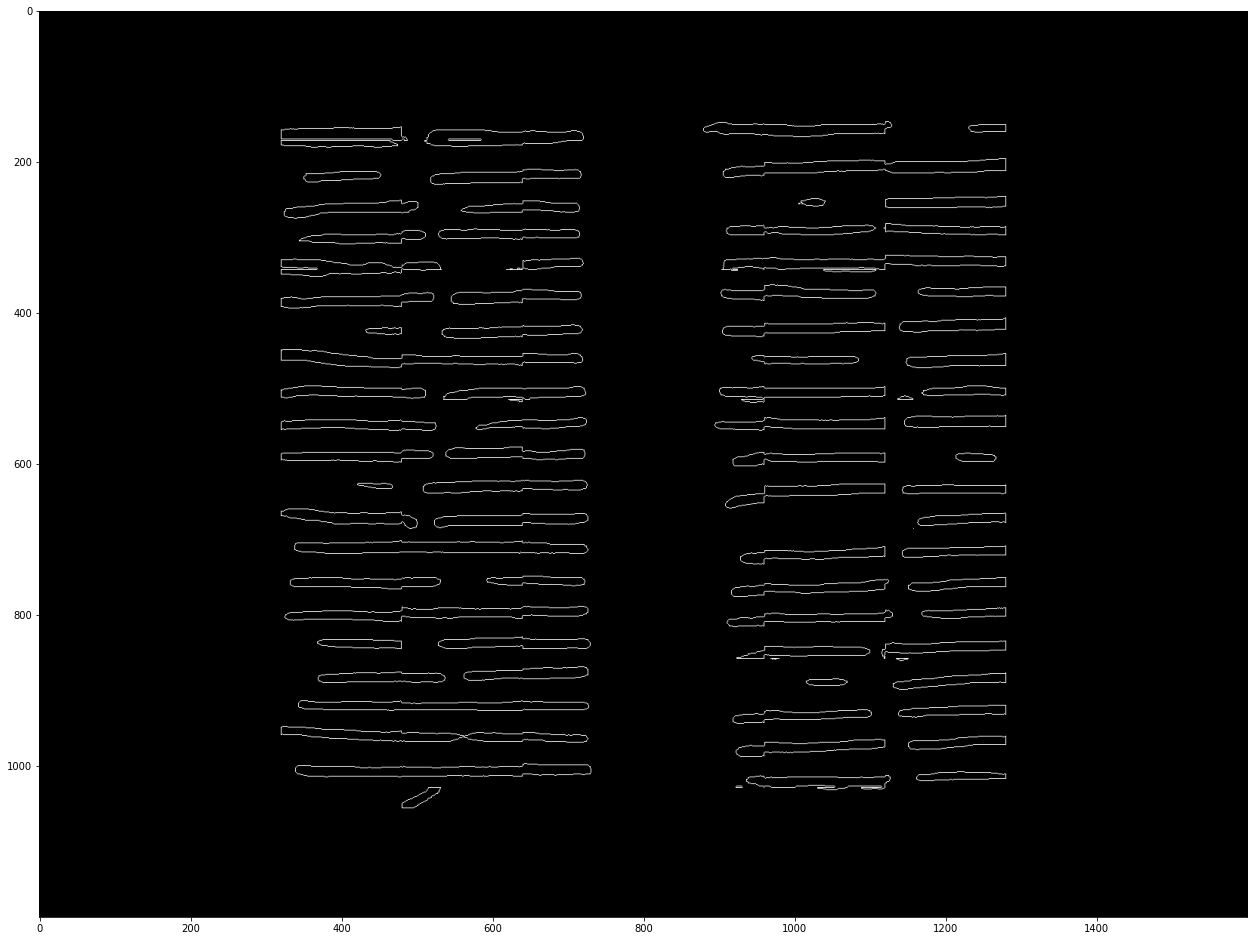

two page image


38

In [ ]:
bboxes = get_bboxes_from_mask(mask=img_mask,
                              x_ratio=cfg['x_ratio'],
                              y_ratio=cfg['y_ratio'],
                              col_width_limit_ratio=cfg["col_width_limit_ratio"],
                              row_height_limit_ratio=cfg["row_height_limit_ratio"],
                              safety_erase_ratio_width=cfg["safety_erase_ratio_width"],
                              safety_erase_ratio_height=cfg["safety_erase_ratio_height"],
                              line_gap_ratio=cfg["line_gap_ratio"],
                              patch_unique_col_size_limit_ratio=cfg["patch_unique_col_size_limit_ratio"])
len(bboxes)

In [ ]:
display_and_save_line_images(bboxes, 
                             img,
                             safety_gap_x=cfg["safety_gap_x"],
                             safety_gap_y=cfg["safety_gap_y"],
                             save=True,
                             img_path=img_path)